In [6]:
#!/usr/bin/env python3
import importlib
import matching
import reconstruction
import bundle_adjustment
import utilis

importlib.reload(matching)
importlib.reload(reconstruction)
importlib.reload(bundle_adjustment)
importlib.reload(utilis)

from matching import FeatureMatcher, MatchConfig
from reconstruction import Reconstruction, ReconstructionCfg
from bundle_adjustment import BundleAdjuster, BAConfig
from utilis import *

# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("SFM")

In [7]:
# ----------------------------------------------------------------------------
# 1) CONFIGURATION & SETUP
# ----------------------------------------------------------------------------


dataset_path = './datasets/templeRing'
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
ext = rename_images_sequentially(dataset_path, valid_extensions=valid_extensions)


# After renaming, use this pattern to load them
img_pattern = f"{{idx:02d}}{ext}"
print(f"Image pattern: {img_pattern}")

output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

reprojection_errors = []
points_history = []

# Get list of image filenames after renaming
image_files = get_image_files(dataset_path, ext=ext)
n_imgs = len(image_files)
logger.info(f"Found {n_imgs} images in {dataset_path}")

# Load camera calibration matrix K
calib_path = Path(dataset_path) / 'K.txt'
K = load_calibration_matrix(calib_path)
logger.info(f"Loaded calibration matrix K:\n{K}")

# Load images
images = []
for idx in range(n_imgs):
    img_path = Path(dataset_path) / img_pattern.format(idx=idx)
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Failed to load image {img_path}")
    images.append(img)
logger.info(f"Loaded {len(images)} images.")


INFO:SFM:Found 46 images in ./datasets/templeRing
INFO:SFM:Loaded calibration matrix K:
[[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
INFO:SFM:Loaded 46 images.


✅ Done renaming images.
Image pattern: {idx:02d}.png


INFO:SFM:Running feature matching pipeline…
INFO:matching:Extracting features...
INFO:matching:Extracted features from 46 images.


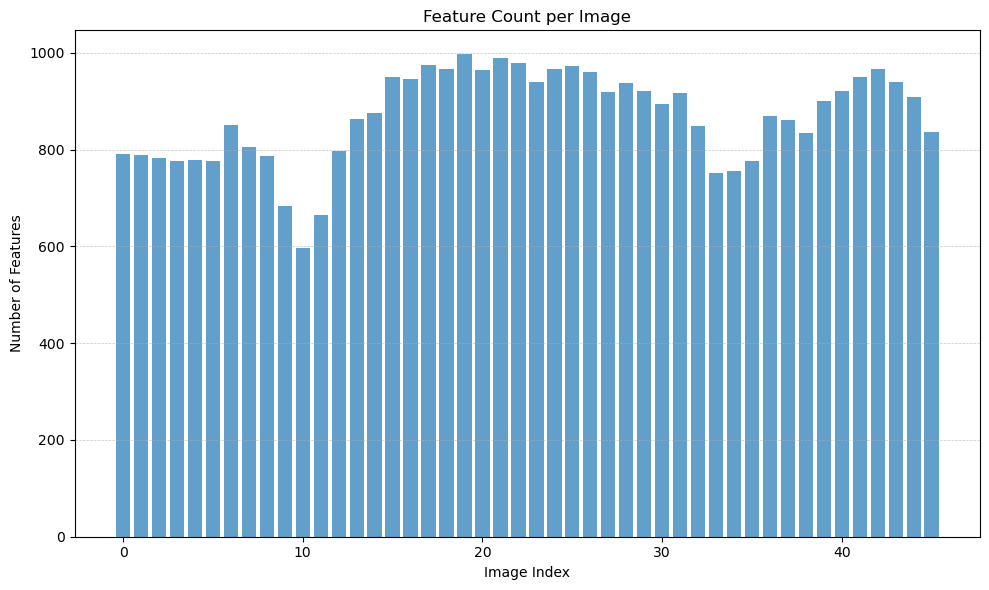

INFO:matching:Matching feature pairs...
INFO:matching:Matched 1035 image pairs.
INFO:matching:Filtering matches with geometric constraints...
INFO:matching:258 pairs left after geometric verification.
INFO:matching:Best pair: (21, 22) with 701 matches


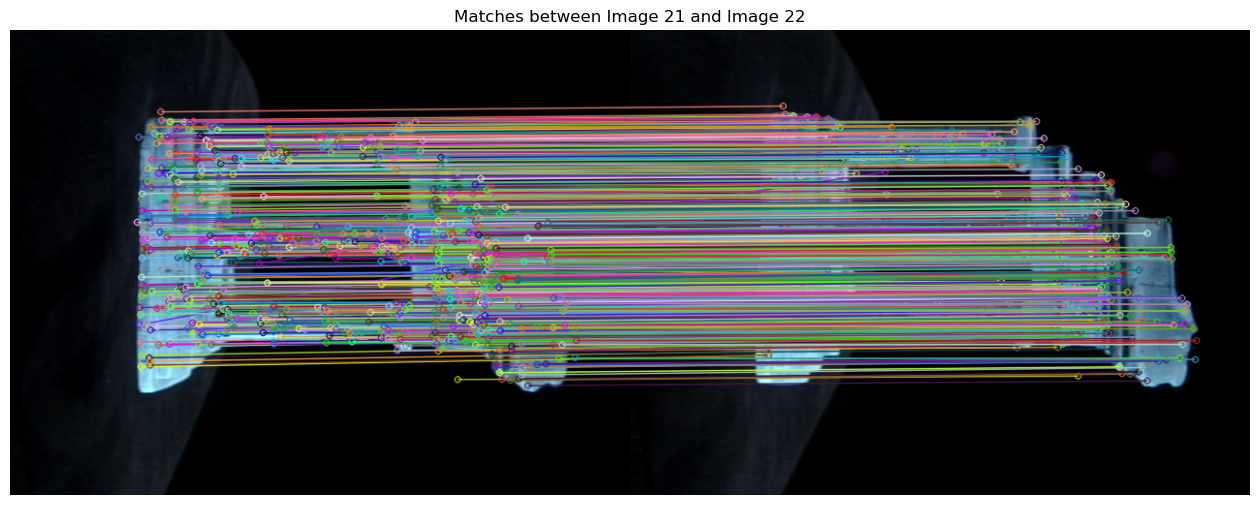

INFO:SFM:✅ Feature matching complete.


In [8]:
# ----------------------------------------------------------------------------
# 2) FEATURE MATCHING
# ----------------------------------------------------------------------------
fm_cfg = MatchConfig(
    dataset_path=dataset_path,
    img_pattern=img_pattern,
    ratio_thresh=0.75,
    ransac_thresh=3.0,
    min_inliers=20,
    use_flann=False,
    nfeatures=0  # Deafult = 0
)

logger.info("Running feature matching pipeline…")
fm = FeatureMatcher(n_imgs=n_imgs, cfg=fm_cfg)
fm.images = images  # Optionally skip reloading images
fm.extract_features()
fm.plot_feature_histogram()
fm.match_pairs()
fm.filter_geometric()
fm.plot_best_match()

# fm.run() # Or call fm.run() to do full pipeline including loading

keypoints = fm.kps
matches = fm.matches
adjacency = fm.adjacency


logger.info("✅ Feature matching complete.")

In [10]:
# ----------------------------------------------------------------------------
# 3) INCREMENTAL RECONSTRUCTION
# ----------------------------------------------------------------------------

import os
cpu_cores = os.cpu_count()
print(f"Detected {cpu_cores} CPU cores")

recon_cfg = ReconstructionCfg(
    K=K,
    min_inliers_baseline=50,
    essential_ransac_thresh=3.0,
    pnp_reproj_thresh=4.0,
    pnp_iterations=500,
    pnp_method= cv2.SOLVEPNP_ITERATIVE, #
    min_pnp_correspondences=10,
    max_failed_attempts=3,
    bundle_every=5,
    verbose=True,
    num_threads = cpu_cores #-> USE min(cpu_cores, 4)
)

recon = Reconstruction(
    keypoints=keypoints,
    matches=matches,
    img_adjacency=adjacency,
    cfg=recon_cfg,
    images=images
)

logger.info("Selecting baseline…")
baseline = recon.select_baseline(top_percent=0.25)
logger.info(f"Baseline selected: {baseline}")

try:
    recon.initialize(baseline)
except Exception as e:
    logger.error(f"Initialization failed: {e}")
    raise

pts3d_initial = [p.coords for p in recon.points3d]
logger.info(f"Starting Points: {len(pts3d_initial)}, Starting Cameras: {len(recon.poses)}")

points_history.append(len(recon.points3d))


INFO:SFM:Selecting baseline…


Detected 16 CPU cores


RuntimeError: No valid baseline pair found (all had too little parallax).

In [5]:
# ----------------------------------------------------------------------------
# 4) SET UP BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------

def run_ba():
    logger.info("Starting bundle adjustment…")
    cam_ids = list(recon.poses.keys())
    n_cams = len(cam_ids)

    init_rvecs = {}
    init_tvecs = {}
    for norm_i, cam in enumerate(cam_ids):
        R, t = recon.poses[cam]
        rvec, _ = cv2.Rodrigues(R)
        init_rvecs[norm_i] = rvec.ravel()
        init_tvecs[norm_i] = t.ravel().reshape(3, 1)

    pts3d_list = [p.coords for p in recon.points3d]
    n_pts = len(pts3d_list)

    cam_idx, pt_idx, pts2d = [], [], []
    for pi, p3d in enumerate(recon.points3d):
        for cam, kpt_i in p3d.observations.items():
            cam_norm = cam_ids.index(cam)
            cam_idx.append(cam_norm)
            pt_idx.append(pi)
            pts2d.append(keypoints[cam][kpt_i].pt)

    cam_idx = np.array(cam_idx)
    pt_idx = np.array(pt_idx)
    pts2d = np.array(pts2d, dtype=np.float64)

    ba_cfg = BAConfig(
        max_nfev=1500,
        ftol=1e-6,
        xtol=1e-6,
        gtol=1e-6,
        loss='huber', #Can use Cauchy, L1, Huber and more
        f_scale=1.0,
        method='trf'
    )

    ba = BundleAdjuster(K, cam_idx, pt_idx, pts2d, n_cams, n_pts,
                        init_rvecs, init_tvecs, pts3d_list, ba_cfg)

    rvecs_opt, tvecs_opt, pts3d_opt = ba.optimize()

    for norm_i, cam in enumerate(cam_ids):
        rvec = rvecs_opt[norm_i]
        tvec = tvecs_opt[norm_i]
        Ropt, _ = cv2.Rodrigues(rvec)
        recon.poses[cam] = (Ropt, tvec)

    for i, xyz in enumerate(pts3d_opt):
        recon.points3d[i].coords = xyz

    params_opt = pack_params(rvecs_opt, tvecs_opt, pts3d_opt)
    avg_error = ba.compute_average_reprojection_error(params_opt)

    reprojection_errors.append(avg_error)
    points_history.append(len(recon.points3d))


logger.info("Bundle adjustment has been set up")

INFO:SFM:Bundle adjustment has been set up


In [6]:
# ----------------------------------------------------------------------------
# 5) GROW RECONSTRUCTION WITH BUNDLE ADJUSTMENT
# ----------------------------------------------------------------------------
from tqdm.notebook import tqdm  # Better support for VSCode/Jupyter
logger.info("Growing reconstruction with live progress…")

max_attempts = 3
pbar = tqdm(total=n_imgs, desc="Images registered", dynamic_ncols=True)
pbar.update(len(recon.poses))  # Initial baseline count

last_pose_count = len(recon.poses)


while len(recon.poses) < n_imgs:
    success = False
    for attempt in range(max_attempts):
        try:
            recon.grow(bundle_adjust_fn=run_ba, pbar=pbar)
            success = True
            break
        except Exception as e:
            logger.warning(f"Reconstruction growth failed: {str(e)}. Retrying...")

    if not success:
        logger.error("Stopping growth. Failed after maximum retries.")
        break

    # If no progress was made since last iteration, stop
    if len(recon.poses) == last_pose_count:
        logger.warning("No new poses were added in this iteration. Stopping to prevent infinite loop.")
        break

    last_pose_count = len(recon.poses)

pbar.close()

INFO:SFM:Growing reconstruction with live progress…


Images registered:   0%|          | 0/46 [00:00<?, ?it/s]

INFO:reconstruction:Added image 21 with 1033 PnP inliers
INFO:reconstruction:Added 242 new colored 3D points during addition of image 21
INFO:reconstruction:Added image 24 with 1392 PnP inliers
INFO:reconstruction:Added 108 new colored 3D points during addition of image 24
INFO:reconstruction:Added image 20 with 1658 PnP inliers
INFO:reconstruction:Added 109 new colored 3D points during addition of image 20
INFO:reconstruction:Added image 19 with 1673 PnP inliers
INFO:reconstruction:Added 135 new colored 3D points during addition of image 19
INFO:reconstruction:Added image 25 with 1710 PnP inliers
INFO:reconstruction:Added 130 new colored 3D points during addition of image 25
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9567e+03                                    4.77e+05    
       1              2         1.8407e+03      1.16e+02       3.40e-04       2.74e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.9567e+03, final cost 1.8407e+03, first-order optimality 2.74e+04.


INFO:reconstruction:Added image 18 with 1694 PnP inliers
INFO:reconstruction:Added 144 new colored 3D points during addition of image 18
INFO:reconstruction:Added image 17 with 1352 PnP inliers
INFO:reconstruction:Added 153 new colored 3D points during addition of image 17
INFO:reconstruction:Added image 26 with 1375 PnP inliers
INFO:reconstruction:Added 168 new colored 3D points during addition of image 26
INFO:reconstruction:Added image 16 with 1190 PnP inliers
INFO:reconstruction:Added 209 new colored 3D points during addition of image 16
INFO:reconstruction:Added image 27 with 1076 PnP inliers
INFO:reconstruction:Added 170 new colored 3D points during addition of image 27
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1881e+03                                    9.18e+04    
       1              2         4.1796e+03      8.51e+00       1.18e-04       1.56e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 4.1881e+03, final cost 4.1796e+03, first-order optimality 1.56e+04.


INFO:reconstruction:Added image 15 with 937 PnP inliers
INFO:reconstruction:Added 151 new colored 3D points during addition of image 15
INFO:reconstruction:Added image 28 with 809 PnP inliers
INFO:reconstruction:Added 188 new colored 3D points during addition of image 28
INFO:reconstruction:Added image 29 with 898 PnP inliers
INFO:reconstruction:Added 240 new colored 3D points during addition of image 29
INFO:reconstruction:Added image 30 with 751 PnP inliers
INFO:reconstruction:Added 115 new colored 3D points during addition of image 30
INFO:reconstruction:Added image 31 with 594 PnP inliers
INFO:reconstruction:Added 124 new colored 3D points during addition of image 31
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8090e+03                                    2.67e+04    
       1              2         5.8072e+03      1.84e+00       6.06e-05       1.16e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 5.8090e+03, final cost 5.8072e+03, first-order optimality 1.16e+04.


INFO:reconstruction:Added image 32 with 563 PnP inliers
INFO:reconstruction:Added 206 new colored 3D points during addition of image 32
INFO:reconstruction:Added image 33 with 589 PnP inliers
INFO:reconstruction:Added 138 new colored 3D points during addition of image 33
INFO:reconstruction:Added image 34 with 662 PnP inliers
INFO:reconstruction:Added 141 new colored 3D points during addition of image 34
INFO:reconstruction:Added image 35 with 798 PnP inliers
INFO:reconstruction:Added 135 new colored 3D points during addition of image 35
INFO:reconstruction:Added image 36 with 844 PnP inliers
INFO:reconstruction:Added 133 new colored 3D points during addition of image 36
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7589e+03                                    1.14e+04    
       1              2         6.7582e+03      7.35e-01       4.16e-05       9.50e+03    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 6.7589e+03, final cost 6.7582e+03, first-order optimality 9.50e+03.


INFO:reconstruction:Added image 37 with 916 PnP inliers
INFO:reconstruction:Added 158 new colored 3D points during addition of image 37
INFO:reconstruction:Added image 38 with 986 PnP inliers
INFO:reconstruction:Added 157 new colored 3D points during addition of image 38
INFO:reconstruction:Added image 39 with 1000 PnP inliers
INFO:reconstruction:Added 129 new colored 3D points during addition of image 39
INFO:reconstruction:Added image 40 with 917 PnP inliers
INFO:reconstruction:Added 141 new colored 3D points during addition of image 40
INFO:reconstruction:Added image 41 with 851 PnP inliers
INFO:reconstruction:Added 198 new colored 3D points during addition of image 41
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0489e+03                                    2.04e+04    
       1              2         8.0475e+03      1.42e+00       5.82e-05       1.03e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 8.0489e+03, final cost 8.0475e+03, first-order optimality 1.03e+04.


INFO:reconstruction:Added image 42 with 812 PnP inliers
INFO:reconstruction:Added 182 new colored 3D points during addition of image 42
INFO:reconstruction:Added image 43 with 754 PnP inliers
INFO:reconstruction:Added 180 new colored 3D points during addition of image 43
INFO:reconstruction:Added image 44 with 690 PnP inliers
INFO:reconstruction:Added 180 new colored 3D points during addition of image 44
INFO:reconstruction:Added image 45 with 662 PnP inliers
INFO:reconstruction:Added 147 new colored 3D points during addition of image 45
INFO:reconstruction:Added image 0 with 673 PnP inliers
INFO:reconstruction:Added 129 new colored 3D points during addition of image 0
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9879e+03                                    3.99e+04    
       1              2         8.9860e+03      1.92e+00       6.12e-05       9.42e+03    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 8.9879e+03, final cost 8.9860e+03, first-order optimality 9.42e+03.


INFO:reconstruction:Added image 1 with 881 PnP inliers
INFO:reconstruction:Added 175 new colored 3D points during addition of image 1
INFO:reconstruction:Added image 2 with 1233 PnP inliers
INFO:reconstruction:Added 176 new colored 3D points during addition of image 2
INFO:reconstruction:Added image 3 with 1097 PnP inliers
INFO:reconstruction:Added 70 new colored 3D points during addition of image 3
INFO:reconstruction:Added image 4 with 890 PnP inliers
INFO:reconstruction:Added 146 new colored 3D points during addition of image 4
INFO:reconstruction:Added image 5 with 881 PnP inliers
INFO:reconstruction:Added 135 new colored 3D points during addition of image 5
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8712e+03                                    4.99e+04    
       1              2         9.8684e+03      2.84e+00       7.99e-05       1.37e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 9.8712e+03, final cost 9.8684e+03, first-order optimality 1.37e+04.


INFO:reconstruction:Added image 14 with 416 PnP inliers
INFO:reconstruction:Added 86 new colored 3D points during addition of image 14
INFO:reconstruction:Added image 13 with 295 PnP inliers
INFO:reconstruction:Added 185 new colored 3D points during addition of image 13
INFO:reconstruction:Added image 12 with 257 PnP inliers
INFO:reconstruction:Added 125 new colored 3D points during addition of image 12
INFO:reconstruction:Added image 11 with 231 PnP inliers
INFO:reconstruction:Added 124 new colored 3D points during addition of image 11
INFO:reconstruction:Added image 10 with 275 PnP inliers
INFO:reconstruction:Added 89 new colored 3D points during addition of image 10
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0589e+04                                    1.37e+04    
       1              2         1.0588e+04      9.44e-01       4.55e-05       1.37e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.0589e+04, final cost 1.0588e+04, first-order optimality 1.37e+04.


INFO:reconstruction:Added image 9 with 341 PnP inliers
INFO:reconstruction:Added 105 new colored 3D points during addition of image 9
INFO:reconstruction:Added image 8 with 396 PnP inliers
INFO:reconstruction:Added 158 new colored 3D points during addition of image 8
INFO:reconstruction:Added image 7 with 682 PnP inliers
INFO:reconstruction:Added 276 new colored 3D points during addition of image 7
INFO:reconstruction:Added image 6 with 895 PnP inliers
INFO:reconstruction:Added 115 new colored 3D points during addition of image 6


In [7]:
# ----------------------------------------------------------------------------
# 6) FINAL BUNDLE ADJUSTMENT AND VISUALIZATION
# ----------------------------------------------------------------------------
logger.info("Running final bundle adjustment…")
run_ba()
visualize_current_state(recon, "Final Reconstruction")

INFO:SFM:Running final bundle adjustment…
INFO:SFM:Starting bundle adjustment…


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1016e+04                                    1.73e+04    


INFO:utilis:Final Reconstruction | Points: 7398, Cameras: 46


       1              2         1.1015e+04      1.07e+00       4.65e-05       1.36e+04    
`xtol` termination condition is satisfied.
Function evaluations 2, initial cost 1.1016e+04, final cost 1.1015e+04, first-order optimality 1.36e+04.


In [8]:
# ----------------------------------------------------------------------------
# 7) SUMMARY LOGGING
# ----------------------------------------------------------------------------
used_images = sorted(recon.poses.keys())
total_3d_points = len(recon.points3d)
avg_error = np.mean(reprojection_errors) if reprojection_errors else -1
avg_points_per_image = total_3d_points / len(used_images) if used_images else 0

logger.info("=" * 60)
logger.info(" Structure from Motion Summary")
logger.info("=" * 60)
logger.info(f" Images used             : {len(used_images)} / {n_imgs}")
logger.info(f" Final 3D points         : {total_3d_points}")
logger.info(f" Avg reprojection error : {avg_error:.2f} pixels")
logger.info(f" Avg 3D pts per image   : {avg_points_per_image:.2f}")
logger.info("=" * 60)


INFO:SFM:============================================================
INFO:SFM: Structure from Motion Summary
INFO:SFM:============================================================
INFO:SFM: Images used             : 46 / 46
INFO:SFM: Final 3D points         : 7398
INFO:SFM: Avg reprojection error : 0.67 pixels
INFO:SFM: Avg 3D pts per image   : 160.83
INFO:SFM:============================================================


In [9]:
# ----------------------------------------------------------------------------
# 8) SAVE FINAL 3D RECONSTRUCTION
# ----------------------------------------------------------------------------
ply_path = output_dir / "templeRing.ply"
# ply_path = output_dir / "house.ply"
save_reconstruction_ply(recon.points3d, ply_path, camera_poses=recon.poses)

INFO:utilis:📁 Saved filtered reconstruction to: outputs/templeRing.ply


In [10]:
# ----------------------------------------------------------------------------
# 9) VISUALIZE TEMPLE RING RECONSTRUCTION IN OPEN3D
# ----------------------------------------------------------------------------
display_saved_reconstruction(str(ply_path))


In [11]:
# # ----------------------------------------------------------------------------
# # 10) VISUALIZE HOUSE RECONSTRUCTION IN OPEN3D
# # ----------------------------------------------------------------------------
# ply_path = output_dir / "reconstruction_House_cams.ply"
# display_saved_reconstruction(str(ply_path))